In [1]:
#Import pycaret
from pycaret.classification import *
import pandas as pd

In [2]:
df=pd.read_csv('Data.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681456 entries, 0 to 681455
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   PRODUCT_CODE                659606 non-null  object 
 1   DOC                         681456 non-null  object 
 2   EXPIRY_DATE                 681456 non-null  object 
 3   PRODUCT_TYPE                681456 non-null  object 
 4   TERMINATION_EFFECTIVE_DATE  623016 non-null  object 
 5   TERM                        681456 non-null  int64  
 6   PREMIUM_AMOUNT              681395 non-null  float64
 7   SA                          681456 non-null  float64
 8   STATUS_NAME                 681456 non-null  object 
 9   PREMIUM_STATUS              681456 non-null  object 
 10  PREMIUM_FREQUENCY           681456 non-null  object 
 11  MODE_NAME                   681456 non-null  object 
 12  GENDER                      681456 non-null  object 
 13  MARITAL_STATUS

In [4]:
#remove date collumns
# convert the 'Date' column to datetime format
df['TERMINATION_EFFECTIVE_DATE']= pd.to_datetime(df['TERMINATION_EFFECTIVE_DATE'])
df['BIRTHDAY']= pd.to_datetime(df['BIRTHDAY'])
df['DOC']= pd.to_datetime(df['DOC'])


#Etract the age from  birth year
#soucrce: https://stackoverflow.com/questions/2217488/age-from-birthdate-in-python
from datetime import date

def calculate_age(born):
    #today = date.today()
    twenty20 = date(2020, 12, 30)
    return twenty20.year - born.year - ((twenty20.month, twenty20.day) < (born.month, born.day))




#Calculate the policy age

df['Policy_Age'] = df['DOC'].apply(calculate_age)
df['Policy_holder_Age'] = df['BIRTHDAY'].apply(calculate_age)

df = df[df.columns.difference(['DOC', 'BIRTHDAY','TERMINATION_EFFECTIVE_DATE','EXPIRY_DATE'])]


In [5]:
df.head()

,AGENT_PERSISTENCY,CLAWBACK_COMMISSION,EDUCATION,GENDER,INCOME,MARITAL_STATUS,MODE_NAME,PREMIUM_AMOUNT,PREMIUM_FREQUENCY,PREMIUM_STATUS,PRODUCT_CODE,PRODUCT_TYPE,Policy_Age,Policy_holder_Age,SA,SALES_CHANNEL,STATUS_NAME,TERM,TERMINATION_REASON
0,86.41,-114.769811,Others,M,111600.0,Single,GSO,302.39,Monthly,Regular,BMFW-1,Risk,12,55,13439.160,Tied,Terminated,7991,FINANCIAL
1,90.25,-83.140400,Others,F,60396.0,Single,DDE,307.74,Monthly,Regular,BMFW-1,Risk,14,47,22689.950,Broker,Lapsed,7992,NaN
2,0.00,0.000000,Others,M,48108.0,Married,GSO,276.58,Monthly,Regular,BMFW-1,Risk,14,65,15938.480,Tied,Terminated,7992,FINANCIAL
3,86.62,-105.602085,Others,M,24000.0,Single,Cash,207.73,Monthly,Regular,BMFW-1,Risk,11,42,11940.525,Tied,Lapsed,7990,NaN
4,82.86,-30.271900,Others,M,55632.0,Married,ESO(Electronic),198.43,Monthly,Regular,BMFW-1,Risk,13,55,12298.740,Broker,Terminated,7992,FINANCIAL


In [6]:
#Shuffle data
df = df.sample(frac=1).reset_index(drop=True)

In [7]:
df.head()
df.shape

(681456, 19)

In [8]:
#Dropt 'Termination reason collumn as it gives away the class'
df.drop(df[df['STATUS_NAME'] == 'Waiting for Validate'].index, inplace = True)

In [9]:
df.shape

(681450, 19)

In [10]:
#Check if the waiting for validate has been removed
df.STATUS_NAME.unique()

array(['Inforce', 'Lapsed', 'Terminated'], dtype=object)

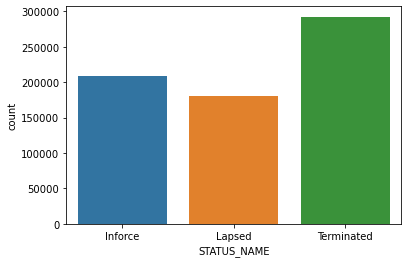

In [11]:
#Simple count plot for class balance inestigation
import seaborn as sns
ax = sns.countplot(x="STATUS_NAME", data=df)

The above plot shows more policies have been terminated foe the data 2014 to 2020.

Data set currently seats at 600k rows. This might be too expensive for computation.
Maybe sampling the data would help reduce that.


In [12]:
#random sample
df2=df.sample(n=50000,replace="False")
df2.shape

(50000, 19)

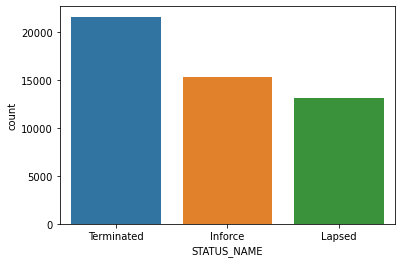

In [15]:
#Check class balance of the sample
#Simple count plot for class balance inestigation
import seaborn as sns
ax = sns.countplot(x="STATUS_NAME", data=df2)

In [13]:
#drop the termination reason
df2=df2.drop(['TERMINATION_REASON'], axis=1)

In [15]:
import gplearn

In [16]:
from gplearn.genetic import SymbolicRegressor

In [17]:
classsifier=SymbolicRegressor()

Seems reasonable to proceed.

In [18]:
#Set up an experiement
exp=setup(df2,target='STATUS_NAME')

,Description,Value
0,session_id,4032
1,Target,STATUS_NAME
2,Target Type,Multiclass
3,Label Encoded,"Inforce: 0, Lapsed: 1, Terminated: 2"
4,Original Data,"(50000, 18)"
5,Missing Values,True
6,Numeric Features,8
7,Categorical Features,9
8,Ordinal Features,False
9,High Cardinality Features,False


In [19]:
#gplearn model
create_model(classsifier)

IntProgress(value=0, description='Processing: ', max=4)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:52:51
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,SymbolicRegressor


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

Note that there are about 50 parameters we can tune here as pre-processing step prior to modelling

In [ ]:
# return best model
Models = compare_models()

In [19]:
#Create xgboost model
xgboost=create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8260,0.9449,0.8126,0.8316,0.8260,0.7295,0.7325
1,0.8069,0.9375,0.7918,0.8118,0.8063,0.6993,0.7025
2,0.8149,0.9419,0.7993,0.8211,0.8148,0.7120,0.7153
3,0.8140,0.9406,0.7998,0.8170,0.8132,0.7109,0.7134
4,0.8209,0.9448,0.8063,0.8249,0.8205,0.7217,0.7243
5,0.8066,0.9354,0.7900,0.8125,0.8059,0.6987,0.7025
6,0.8069,0.9384,0.7910,0.8099,0.8055,0.6994,0.7024
7,0.8023,0.9322,0.7869,0.8078,0.8020,0.6924,0.6955
8,0.8014,0.9350,0.7832,0.8077,0.8005,0.6904,0.6946
9,0.7997,0.9347,0.7845,0.8054,0.7997,0.6886,0.6915


In [47]:
#model object
xgboost

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=3844, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [20]:
interpret_model(xgboost, plot = 'reason', observation = 9)

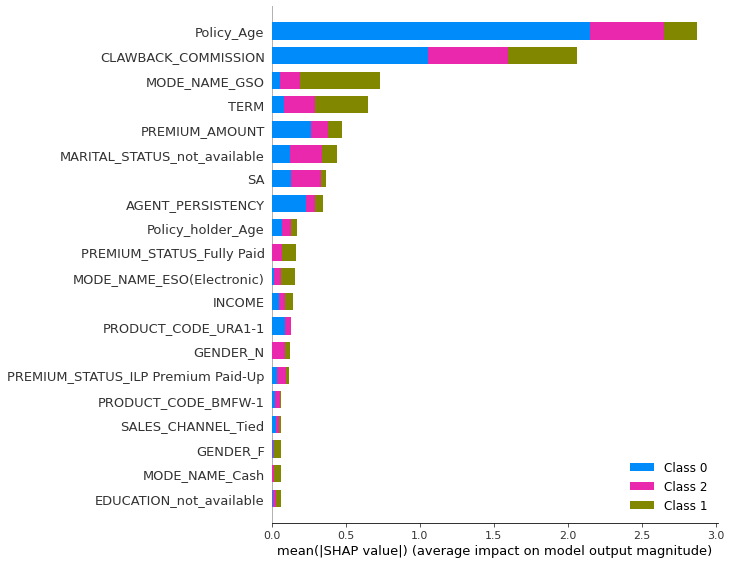

In [48]:
interpret_model(xgboost)

In [69]:
evaluate_model(xgboost)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

Looking at the prediction error plot most of the policies weremisclassified accross termination and lapsed.In  one of the literature investigating lapses in life insurance, lapses were treated same as terminations.This  could be a basis to turn this into a binary classification

In [71]:
#Assume Terminated=Lapsed
df2['STATUS_NAME'] = df2['STATUS_NAME'].str.replace('Terminated','Lapsed')

In [76]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 551234 to 68153
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AGENT_PERSISTENCY    50000 non-null  float64
 1   CLAWBACK_COMMISSION  20091 non-null  float64
 2   EDUCATION            22249 non-null  object 
 3   GENDER               50000 non-null  object 
 4   INCOME               36730 non-null  float64
 5   MARITAL_STATUS       36743 non-null  object 
 6   MODE_NAME            50000 non-null  object 
 7   PREMIUM_AMOUNT       49996 non-null  float64
 8   PREMIUM_FREQUENCY    50000 non-null  object 
 9   PREMIUM_STATUS       50000 non-null  object 
 10  PRODUCT_CODE         48388 non-null  object 
 11  PRODUCT_TYPE         50000 non-null  object 
 12  Policy_Age           50000 non-null  int64  
 13  Policy_holder_Age    50000 non-null  int64  
 14  SA                   50000 non-null  float64
 15  SALES_CHANNEL        50000 non-

In [72]:
exp=setup(df2,target='STATUS_NAME')

,Description,Value
0,session_id,2078
1,Target,STATUS_NAME
2,Target Type,Binary
3,Label Encoded,"Inforce: 0, Lapsed: 1"
4,Original Data,"(50000, 18)"
5,Missing Values,True
6,Numeric Features,8
7,Categorical Features,9
8,Ordinal Features,False
9,High Cardinality Features,False


In [73]:
# return best model
Models = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9315,0.9668,0.9844,0.9222,0.9522,0.8318,0.8374,0.5740
xgboost,Extreme Gradient Boosting,0.9313,0.9663,0.9819,0.9238,0.9520,0.8317,0.8365,5.8050
gbc,Gradient Boosting Classifier,0.9287,0.9622,0.9823,0.9203,0.9503,0.8248,0.8303,5.1010
ada,Ada Boost Classifier,0.9247,0.9573,0.9755,0.9207,0.9473,0.8161,0.8204,1.3580
rf,Random Forest Classifier,0.9187,0.9360,0.9589,0.9264,0.9424,0.8043,0.8058,1.9270
dt,Decision Tree Classifier,0.8953,0.8916,0.9253,0.9239,0.9245,0.7535,0.7535,0.2220
et,Extra Trees Classifier,0.8583,0.8925,0.9084,0.8896,0.8989,0.6622,0.6626,2.7160
lda,Linear Discriminant Analysis,0.8127,0.8584,0.9099,0.8348,0.8707,0.5328,0.5395,0.5070
ridge,Ridge Classifier,0.8124,0.0000,0.9190,0.8290,0.8717,0.5263,0.5362,0.0780
knn,K Neighbors Classifier,0.7594,0.7957,0.8234,0.8286,0.8260,0.4363,0.4364,1.4950


In [74]:
LGBT=create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9286,0.9677,0.9843,0.9185,0.9503,0.8240,0.8303
1,0.9306,0.9649,0.9835,0.9216,0.9516,0.8295,0.8350
2,0.9394,0.9706,0.9852,0.9314,0.9575,0.8522,0.8562
3,0.9263,0.9602,0.9806,0.9186,0.9486,0.8189,0.8244
4,0.9286,0.9654,0.9852,0.9179,0.9503,0.8238,0.8304
5,0.9303,0.9649,0.9835,0.9213,0.9514,0.8287,0.8343
6,0.9323,0.9721,0.9868,0.9212,0.9529,0.8332,0.8395
7,0.9343,0.9715,0.9839,0.9259,0.9541,0.8391,0.8439
8,0.9323,0.9672,0.9839,0.9234,0.9527,0.8340,0.8392
9,0.9328,0.9632,0.9868,0.9218,0.9532,0.8347,0.8408


In [75]:
evaluate_model(LGBT)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

Discrimination threshold:https://www.scikit-yb.org/en/latest/api/classifier/threshold.html#:~:text=The%20discrimination%20threshold%20is%20the,chosen%20over%20the%20negative%20class.&text=Generally%20speaking%2C%20the%20threshold%20is,to%200.5%20or%2050%25%20probability.

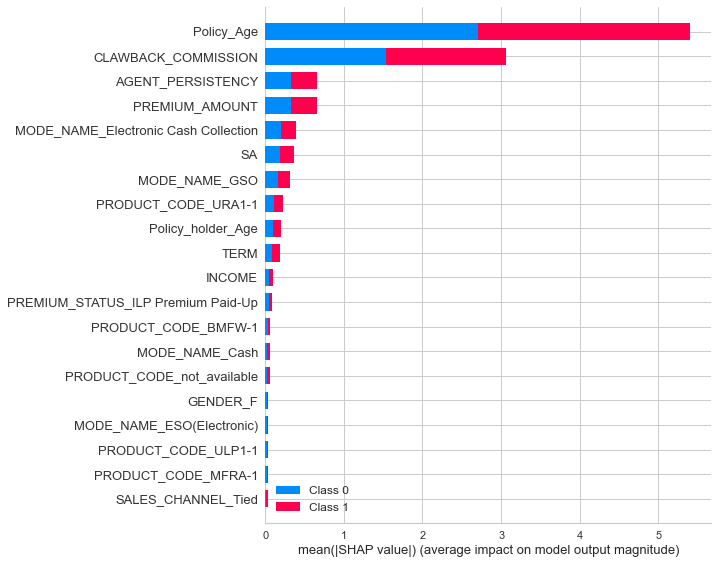

In [77]:
interpret_model(LGBT,)

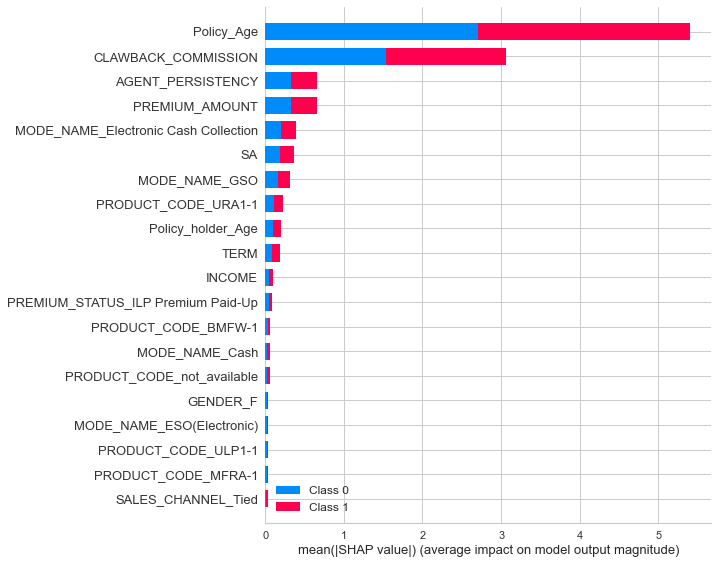

In [111]:
interpret_model(LGBT,plot='summary')

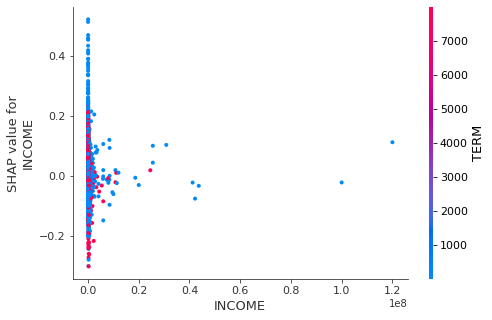

In [31]:
interpret_model(xgboost,plot = 'correlation',feature='INCOME')

In [81]:
y_test=get_config('y_test')
X_test=get_config('X_test')

In [82]:
predictions=pred_holdout = predict_model(LGBT)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9354,0.9718,0.9835,0.9282,0.9550,0.8409,0.8453


In [97]:
#This function predicts Label and Score (probability of predicted class) using a trained model. 
#When data is None, it predicts label and score on the holdout set.
predictions.head(20)


,AGENT_PERSISTENCY,CLAWBACK_COMMISSION,INCOME,PREMIUM_AMOUNT,Policy_Age,Policy_holder_Age,SA,TERM,EDUCATION_Others,EDUCATION_Unknown,...,PRODUCT_CODE_URA1-1,PRODUCT_CODE_URA2-1,PRODUCT_CODE_URAG-1,PRODUCT_CODE_WPLA-1,PRODUCT_CODE_not_available,PRODUCT_TYPE_Risk,SALES_CHANNEL_Tied,STATUS_NAME,Label,Score
0,0.000000,-1039.714233,46536.000000,213.500000,16.0,54.0,0.000000,24.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lapsed,Lapsed,0.9999
1,0.000000,-1039.714233,218697.046875,80.000000,4.0,68.0,10000.000000,7983.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Lapsed,Lapsed,0.7698
2,0.000000,-1039.714233,218697.046875,50.000000,5.0,96.0,7500.000000,7984.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Lapsed,Lapsed,0.8759
3,65.540001,-1039.714233,172720.000000,410.959991,3.0,57.0,0.000000,11.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Inforce,Inforce,0.9686
4,0.000000,-1039.714233,218697.046875,60.000000,3.0,32.0,15000.000000,7982.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Lapsed,Lapsed,0.9018
5,62.220001,0.000000,94836.000000,255.000000,7.0,45.0,0.000000,19.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Lapsed,Lapsed,0.9992
6,0.000000,-1039.714233,372720.000000,88.000000,25.0,54.0,0.000000,26.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lapsed,Lapsed,0.9998
7,84.809998,-50.747299,31200.000000,166.479996,7.0,39.0,15913.500000,7985.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Lapsed,Lapsed,0.9986
8,0.000000,-1039.714233,218697.046875,50.000000,3.0,25.0,4000.000000,7981.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Lapsed,Lapsed,0.9361
9,72.879997,-3264.407959,42648.000000,336.000000,0.0,33.0,25000.000000,7979.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Inforce,Lapsed,0.8503


In [86]:
#Get the misclassifications
predictions.loc[(predictions['STATUS_NAME'] != predictions['Label'])]

,AGENT_PERSISTENCY,CLAWBACK_COMMISSION,INCOME,PREMIUM_AMOUNT,Policy_Age,Policy_holder_Age,SA,TERM,EDUCATION_Others,EDUCATION_Unknown,...,PRODUCT_CODE_URA1-1,PRODUCT_CODE_URA2-1,PRODUCT_CODE_URAG-1,PRODUCT_CODE_WPLA-1,PRODUCT_CODE_not_available,PRODUCT_TYPE_Risk,SALES_CHANNEL_Tied,STATUS_NAME,Label,Score
9,72.879997,-3264.407959,42648.000000,336.000000,0.0,33.0,25000.000000,7979.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Inforce,Lapsed,0.8503
30,0.000000,-1039.714233,218697.046875,80.000000,5.0,80.0,10000.000000,7984.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Inforce,Lapsed,0.7544
46,0.000000,-1039.714233,218697.046875,80.000000,3.0,78.0,10000.000000,7982.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Inforce,Lapsed,0.6921
136,0.000000,-1039.714233,218697.046875,80.000000,3.0,70.0,10000.000000,7982.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Inforce,Lapsed,0.7074
153,85.160004,-21.082649,62220.000000,182.339996,5.0,27.0,28137.720703,7983.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Lapsed,Inforce,0.5695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14961,78.949997,-694.658264,21600.000000,143.000000,3.0,43.0,35000.000000,7982.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Inforce,Lapsed,0.8795
14962,59.110001,-1039.714233,217632.000000,750.000000,2.0,54.0,0.000000,17.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Lapsed,Inforce,0.9719
14971,0.000000,-1039.714233,218697.046875,80.000000,1.0,75.0,10000.000000,7980.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Inforce,Lapsed,0.5380
14973,81.669998,-1039.714233,218697.046875,50.000000,4.0,27.0,4000.000000,7983.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Inforce,Lapsed,0.8911


In [1]:
#Lapsed correct prediction
interpret_model(LGBT, plot = 'reason', observation = 9)

NameError: name 'interpret_model' is not defined

In [102]:
#prediction 19 : lapse
#Lapsed correct prediction
interpret_model(LGBT, plot = 'reason', observation = 18)

In [101]:
#Inforce correct prediction
interpret_model(LGBT, plot = 'reason', observation = 16)

In [103]:
#Inforce correct prediction
interpret_model(LGBT, plot = 'reason', observation = 15)

the SHAP values of all features sum up to explain why my prediction was different from the baseline. This allows us to decompose a prediction in a graph like this:


We predicted -0.12 whereas base value was 2.191.
Feature values causing increased predictions are in pink.
The visual size shows the magnitude of the feature effect.
Feature values decreasing the prediction are in blue
The biggest impact comes from CLAWBACK COMMISION -1888
Though the Policy age value has a meaningful effect increasing the prediction.


If you subtract the length of the blue bars from the length of the pink bars, it equals the distance from the base value to the output.

Inforces seem to be far away from the base values -------> high fx value

In [105]:
#Wrong predictions
#Actual= infrorce but predicted Lapse
interpret_model(LGBT, plot = 'reason', observation = 9)


The fx is very close to base value=====> lapse

In [107]:
#Lapse but predicted inforce
interpret_model(LGBT, plot = 'reason', observation = 14973)

Wrong predictions appear to not have a big difference between base and fx
The above graphs are showing the base value (the average model output over the training dataset),
compared to the model output. Shown in red are the variables pushing the prediction higher, while the
opposite holds true for the variables in blue.
https://parker-fitzgerald.com/wp-content/uploads/2019/12/ML-Interpretability-SHAP-example.pdf

In [110]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 551234 to 68153
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AGENT_PERSISTENCY    50000 non-null  float64
 1   CLAWBACK_COMMISSION  20091 non-null  float64
 2   EDUCATION            22249 non-null  object 
 3   GENDER               50000 non-null  object 
 4   INCOME               36730 non-null  float64
 5   MARITAL_STATUS       36743 non-null  object 
 6   MODE_NAME            50000 non-null  object 
 7   PREMIUM_AMOUNT       49996 non-null  float64
 8   PREMIUM_FREQUENCY    50000 non-null  object 
 9   PREMIUM_STATUS       50000 non-null  object 
 10  PRODUCT_CODE         48388 non-null  object 
 11  PRODUCT_TYPE         50000 non-null  object 
 12  Policy_Age           50000 non-null  int64  
 13  Policy_holder_Age    50000 non-null  int64  
 14  SA                   50000 non-null  float64
 15  SALES_CHANNEL        50000 non-